# PUC Minas
## Pós Graduação em Ciência de Dados e Big Data (2018-2019)
## Trabalho de Conclusão de Curso
### Aluno: Igor Ribeiro Braga

Este notebook é relativo ao meu Trabalho de Conclusão de Curso em Ciência de Dados e Big Data. O título é **Séries Temporais de Receitas Orçamentárias da Prefeitura Municipal de João Pessoa e Predição de Valores Orçamentários**, neste trabalho o dataset foi baixado no site do [TCE-PB](http://tce.pb.gov.br/servicos/dados-abertos-do-sagres-tce-pb), especificamente a Tabela: Receita Orçamentária da Esfera Municipal. Para fazer o download diretamente, clique [aqui](https://dados.tce.pb.gov.br/TCE-PB-SAGRES-Receita_Orcamentaria_Esfera_Municipal.txt.gz). O dataset deve ser salvo na pasta `datasets` na pasta raiz deste notebook.

### Leitura dos dados e importação das bibliotecas utilizadas

Para iniciar o trabalho, o primeiro passo é fazer o downlad do *dataset* com os links disponibilizados acima e armazená-lo na pasta `datasets`. Assim, o documento pode ser lido sem maiores problemas.

No código abaixo, as importações das bibliotecas utilizadas e a definição de um método para facilitar a visualização dos valores em moeda Real (R$).

In [282]:
# Imports das bibliotecas utilizadas
import locale
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA


# Define valores padrão para as figuras do matplotlib
rcParams['figure.figsize'] = 15, 6

# Função para converter Float em Currency
locale.setlocale(locale.LC_MONETARY, 'pt_BR.UTF-8')

def em_reais(valor):
    '''
    Função para exibir os valores em reais.
    '''
    return locale.currency(valor, grouping=True)

def show_value_counts(serie, column_desc=None, grain='Registers', 
                      size=None, total=None, title=None, height=10, index=None):
    '''
    Função que plota os value_counts de uma série.
    '''
    fig = plt.figure()
    fig.set_size_inches(15, height)

    ax1 = plt.subplot(1,1,1)

    serie = serie.value_counts().sort_values(ascending=True)

    if not total:
        total = serie.sum()
    
    corte = ''
    
    if (index):
        serie = serie.rename(index)
    
    if serie.index.dtype != 'object':
        if serie.index.dtype == 'float64':
            serie.index = serie.index.map(int)
        serie.index = serie.index.map(str)
    serie.index = serie.index.map(str)
    
    if size and len(serie) > size:
        serie = serie.sort_values(ascending=False)
        serie = serie[:size]
        serie = serie.sort_values(ascending=True)
        corte = ' ({} most frequents)'.format(size)
    
    if not title:
        if column_desc:
            column = column_desc
        else:
            column = serie.name
        title = "#{} by {}{}".format(grain, column, corte)
   
    ax1.barh(serie.index, serie, align='center', color='c', ecolor='black')
    percentage = serie/total*100
    number_distance = serie.max()*0.005
    
    for i, v in enumerate(serie):
        pct = locale.format('%.2f', percentage[i], True)
        ax1.text(v+number_distance , i-0.2, '{0:,} ({1}%)'.format(v, pct), color='k')
    ax1.set(title=title,
           xlabel='',
           ylabel='')
    sns.despine(left=True, bottom=True)

    plt.show()
    plt.show()

def teste_adf(serie):
    result = adfuller(serie)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


Para a leitura do dataset, foi definido os tipos das colunas **cd_ugestora**, **dt_mesano** e **dt_ano**.

In [283]:
# Definindo tipos das colunas antes de ler o dataset
columns_types = {'cd_ugestora': str, 'dt_mesano': str, 'dt_ano': int}

# Carrega os dados usando pandas
receitas = pd.read_csv('datasets/TCE-PB-SAGRES-Receita_Orcamentaria_Esfera_Municipal.txt',sep='|',dtype=columns_types,encoding='utf-8')

O dataset possui os dados de todas as entidade públicas da esfera municipal do estado da Paraíba, mas este estudo, apenas a **Prefeitura Municipal de João Pessoa** será utilizada. Portanto um filtro é aplicado e cria-se um novo Pandas Dataframe.

In [284]:
# Obtém todos os dados da Prefeitura Municipal de João Pessoa (cd_ugestora=201095)
pref_mun_joao_pessoa = receitas[receitas['cd_ugestora'] == '201095']

# Mostra informações sobre o dataset
pref_mun_joao_pessoa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7749 entries, 487846 to 628083
Data columns (total 9 columns):
cd_ugestora              7749 non-null object
de_ugestora              7749 non-null object
dt_ano                   7749 non-null int64
cd_receitaorcug          7749 non-null int64
de_receitaorcug          7516 non-null object
tp_atualizacaoreceita    7749 non-null int64
de_atualizacaoreceita    7749 non-null object
vl_lancamentoOrc         7749 non-null float64
dt_mesano                7749 non-null object
dtypes: float64(1), int64(3), object(5)
memory usage: 605.4+ KB


Acima, um resumo do dataset disponibilizado pelo Pandas. Nele, podemos verificar quais as colunas presentes, qual o tipo de dado cada coluna foi carregada e quantos objetos não nulos temos por coluna. Neste exemplo podemos verificar que a coluna **de_receitaorcug** possui valores nulos.

In [285]:
# Descrição do dataset
pref_mun_joao_pessoa.describe()

,dt_ano,cd_receitaorcug,tp_atualizacaoreceita,vl_lancamentoOrc
count,7749.000000,7.749000e+03,7749.000000,7.749000e+03
mean,2010.379275,1.507647e+08,1.197574,2.410722e+06
std,4.956292,1.113795e+09,0.594949,5.512834e+06
min,2003.000000,1.000000e+00,1.000000,0.000000e+00
25%,2006.000000,1.121250e+07,1.000000,2.655952e+04
50%,2010.000000,1.721010e+07,1.000000,2.675004e+05
75%,2015.000000,1.761000e+07,1.000000,1.600073e+06
max,2019.000000,9.517214e+09,5.000000,8.593407e+07


Com o método *describe* do Pandas obtemos informações sobre o dataset como:
1. count: Quantidade de registros
1. mean: Mediana
1. std: Desvio padrão
1. min: Valor mínimo
1. 25%: Primeiro quartil
1. 50%: Segundo quartil
1. 75%: Terceiro quartil
1. máx: Valor máximo

Abaixo são demonstrados quais são os tipos de receitas que uma prefeitura como a de João Pessoa recebe por mês.

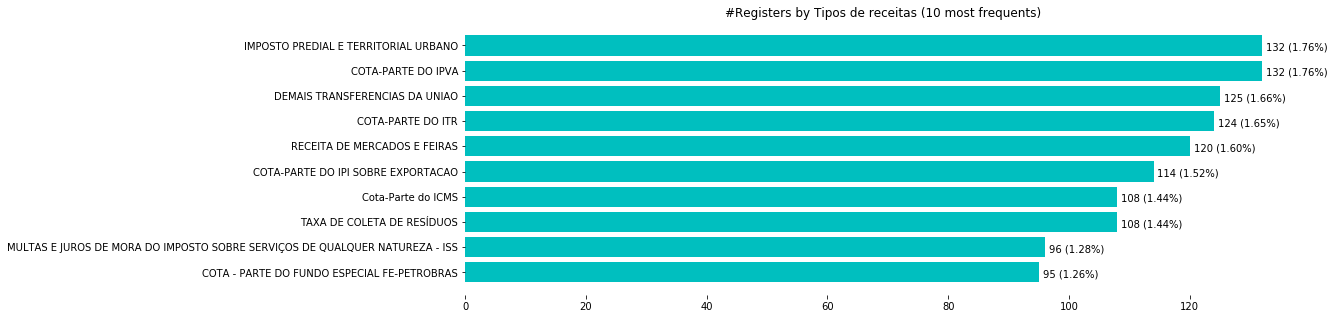

In [286]:
# Tipos de receitas que o Município recebe:
# Aqui, os valores não são referentes ao total em receita, mas quantas vezes aparece no dataset.
show_value_counts(pref_mun_joao_pessoa['de_receitaorcug'],size=10,column_desc='Tipos de receitas',height=5)

Vamos verificar se o dataset possui colunas com dados nulos.

In [287]:
# Identificando valores Nulos em colunas
pref_mun_joao_pessoa.isna().any()

cd_ugestora              False
de_ugestora              False
dt_ano                   False
cd_receitaorcug          False
de_receitaorcug           True
tp_atualizacaoreceita    False
de_atualizacaoreceita    False
vl_lancamentoOrc         False
dt_mesano                False
dtype: bool

É identificado que a coluna **de_receitaorcug** possui dados nulos. Essa coluna é de descrição das receitas recebidas pela unidade de gestão. Abaixo iremos preencher com uma string padrão.

In [288]:
# Preenchendo os valores nulos
pref_mun_joao_pessoa.de_receitaorcug.fillna('Sem descrição', inplace=True)

/home/irbraga/.local/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Após preencher a coluna que possui dados nulos, verificar se ficou alguma coluna com dados nulos.

In [289]:
# Identificando valores Nulos em colunas
pref_mun_joao_pessoa.isna().any()

cd_ugestora              False
de_ugestora              False
dt_ano                   False
cd_receitaorcug          False
de_receitaorcug          False
tp_atualizacaoreceita    False
de_atualizacaoreceita    False
vl_lancamentoOrc         False
dt_mesano                False
dtype: bool

Analisando outras entidade públicas no dataset, identiquei que algumas delas possuiam datas com meses incoerentes, como `13` por exemplo. Assim, vou verificar na coluna **dt_mesano** e pegar os 2 primeiros dígitos do meses (formato MMYYYY) e listar para verificar se algum possui esse dado incoerente.

In [290]:
# Certificando se possuem meses incoerentes
pref_mun_joao_pessoa.dt_mesano.str.slice(0,2).value_counts()

07    683
12    673
06    671
05    660
04    651
08    638
10    637
01    636
03    635
11    630
09    626
02    609
Name: dt_mesano, dtype: int64

Nesse caso os dados só possuem valores de meses válidos.

Sabendo que os dados da coluna **dt_mesano** estão coerentes, vou mudar o tipo de dado da coluna pata `datetime`.

In [291]:
# Convertendo a coluna Mês/Ano em Datetime
pref_mun_joao_pessoa['dt_mesano'] = pd.to_datetime(pref_mun_joao_pessoa['dt_mesano'], format='%m%Y')

/home/irbraga/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Com o dataset suficientemente validado, podemos iniciar o processo de análise dos dados.

### Análise inicial do dados e obtenção de informações do dataset

Para iniciar o estudo do dataset, alguns questionamentos vieram a mente:

1. Quais os valores recebidos por ano?
1. Quais os valores recebidos por mês/ano?
1. Como se comporta a série temporal do total de receitas mês/ano do Município?
1. Como se fazer forecasting de valores orçamentários baseados no dataset?

Bem, vamos começar pela primeira pergunta:

#### 1. Quais os valores recebidos por ano?

Para responder a essa pergunta, vamos primeiro remover as colunas que não agregam informação para isso em um novo Dataframe.

In [292]:
# Criar novo dataframe apenas com os dados que importam
receitas_por_ano = pref_mun_joao_pessoa.drop(columns=['cd_ugestora','de_ugestora','cd_receitaorcug','de_receitaorcug','tp_atualizacaoreceita','de_atualizacaoreceita','dt_mesano'])
receitas_por_ano.head()

,dt_ano,vl_lancamentoOrc
487846,2007,112414.55
487847,2007,96588.89
487848,2007,112195.04
487849,2007,96514.83
487850,2007,100358.00


Aqui temos as várias entradas de receitas por mês dos anos de 2003 a 2018. No momento, queremos esses valores agrupados e somados por ano.

In [293]:
# Agrupar e calcular a soma da coluna vl_lancamentoOrc
receitas_por_ano['total'] = receitas_por_ano.groupby('dt_ano').transform('sum')
receitas_por_ano = receitas_por_ano.drop(columns=['vl_lancamentoOrc'])

In [294]:
# Removendo duplicatas e ordenando pelo ano
receitas_por_ano.drop_duplicates(keep='first', inplace=True)
receitas_por_ano.sort_values(by=['dt_ano'],ascending=True,inplace=True)

In [295]:
# Definindo o ano como índice
receitas_por_ano.set_index('dt_ano',inplace=True)
receitas_por_ano.head()

,total
dt_ano,
2003,4.269491e+08
2004,5.309502e+08
2005,6.393762e+08
2006,7.121140e+08
2007,8.121067e+08


Agora podemos exibir o primeiro gráfico, o de totais de receitas por ano.

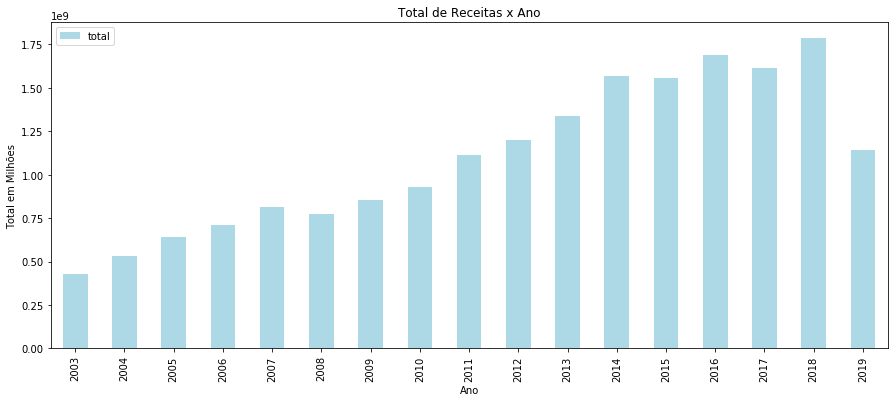

In [296]:
# Plotando gráfico: Total de recebimentos x Ano
ax = receitas_por_ano.plot(kind='bar',color='lightblue',title='Total de Receitas x Ano')

ax.set_ylabel('Total em Milhões')
ax.set_xlabel('Ano')

plt.show()

Como demonstrado no gráfico acima, o ano de 2018 foi o ano que mais acumulou receitas desde 2003. Abaixo temos um resumo de informações sobre o dados do agrupamento desses valores, como os quartis(25%, 50% e 75%), a média (mean), o desvio padrão (std) e os valores máximos e mínimos.

Mais abaixo, temos um gráfico bloxplot que evidencia essas informação graficamente.

In [297]:
# Informações sobre o desvio padrão, valores máximo e mínimo e os percentiles.
receitas_por_ano.describe()

,total
count,1.700000e+01
mean,1.098864e+09
std,4.326471e+08
min,4.269491e+08
25%,7.760248e+08
50%,1.112647e+09
75%,1.558121e+09
max,1.787108e+09


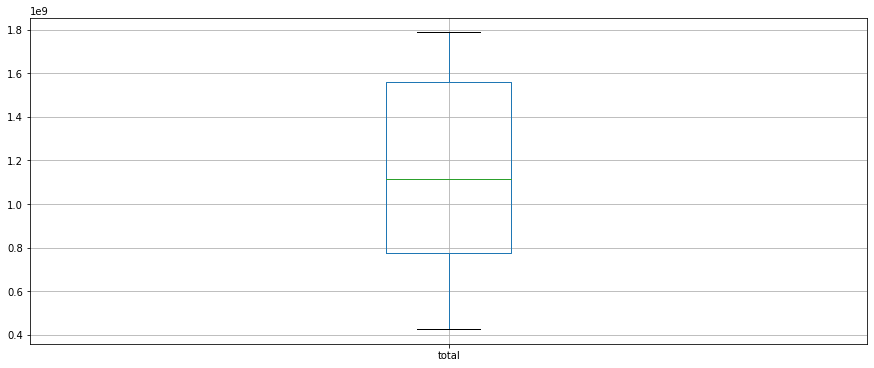

In [298]:
# Gráfico bolxplot dos totais de receitas recebidas entre os anos de 2003 e 2019
receitas_por_ano.boxplot()

In [299]:
# Ano que ocorreu o maior valor total de receitas
receitas_por_ano.idxmax(axis=0)

total    2018
dtype: int64

In [300]:
# Maior valor total de receitas recebidos em um mesmo ano
em_reais(receitas_por_ano.loc[2018]['total'])

'R$ 1.787.107.723,33'

Com o gráfico fica mais evidente a proporção dos valores recebidos por ano, e com isso pudemos identificar o ano que mais acumulou receita e o valor total acumulado.

**2018: R$ 1.787.108.000,00**

Mais da metade dos anos presentes no dataset mostram valores que são marcados como **outliers**, sejam eles superiores ou inforiores aos percentis. Isso pode ser devido a meses no ano em que as arrecadações sobem consideravelmente por eventos que ocorrem em intervalo de tempo, como prazos limites de pagamentos de impostos ou recebimentos de receitas que sofreram atrasos em alguns anos.  

Mais abaixo iremos detalhar melhor os dados mensalmente. E rever esse mesmo gráfico agrupado por mês e verificar seu comportamento.

#### 2. Quais os valores recebidos por mês/ano?

A análise aqui será similar a da pergunta anterior, mas levando em consideração da coluna **dt_mesano** ao invés da **dt_ano**.

In [435]:
# Criar novo dataframe apenas com os dados que importam
receitas_por_mes_ano = pref_mun_joao_pessoa.drop(columns=['cd_ugestora','de_ugestora','cd_receitaorcug','de_receitaorcug','tp_atualizacaoreceita','de_atualizacaoreceita','dt_ano'])
receitas_por_mes_ano.head()

,vl_lancamentoOrc,dt_mesano
487846,112414.55,2007-01-01
487847,96588.89,2007-02-01
487848,112195.04,2007-03-01
487849,96514.83,2007-04-01
487850,100358.00,2007-05-01


In [436]:
# Agrupar e calcular a soma da coluna vl_lancamentoOrc
receitas_por_mes_ano['total'] = receitas_por_mes_ano.groupby('dt_mesano').transform('sum')
receitas_por_mes_ano = receitas_por_mes_ano.drop(columns=['vl_lancamentoOrc'])

In [437]:
# Removendo duplicatas
receitas_por_mes_ano.drop_duplicates(keep='first', inplace=True)
receitas_por_mes_ano.sort_values(by=['dt_mesano'],ascending=True,inplace=True)

In [438]:
# Definindo o mês/ano como índice
receitas_por_mes_ano.set_index('dt_mesano',inplace=True)
receitas_por_mes_ano.head()

,total
dt_mesano,
2003-01-01,46923205.80
2003-02-01,31463697.81
2003-03-01,34147830.15
2003-04-01,29138516.65
2003-05-01,38139457.19


Como os dados tratados aqui agora são os meses do ano, a visualização do gráfico utilizando barras não fica bom pois serão plotados os meses e as informações sobre os meses no eixo X ficarão sobrepostos. Portanto vou criar um gráfico em linha. Isso também irá nos ambientar para nosso futuro estudo sobre a série temporal orçamentária.

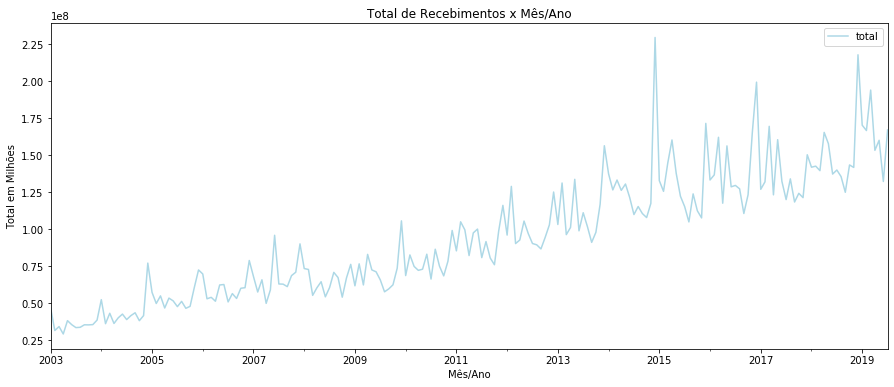

In [439]:
# Plotando gráfico: Total de recebimentos x Mês/Ano
ax = receitas_por_mes_ano.plot(kind='line',color='lightblue',title='Total de Recebimentos x Mês/Ano')

ax.set_ylabel('Total em Milhões')
ax.set_xlabel('Mês/Ano')

plt.show()

In [396]:
# Dados estatísticos
receitas_por_mes_ano.describe()

,total
count,1.990000e+02
mean,9.387277e+07
std,4.116992e+07
min,2.913852e+07
25%,6.045014e+07
50%,9.002253e+07
75%,1.252799e+08
max,2.294779e+08


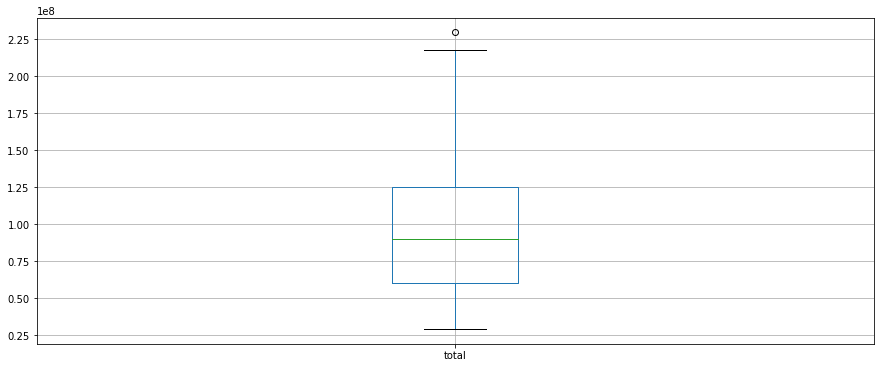

In [397]:
# Gráfico Bloxplot com os quartis, outliers, valores mínimos e máximos
receitas_por_mes_ano.boxplot()

Aqui o gráfico mostra que a média dos valores se encontra bem mais próxima do limite inferior do que o limite superior. Isso mostra que quando enxergamos os dados da perspectica mensal os dados podem ter um comportamento diferente que o anual, que demonstrou ser mais distribuída ao longo do tempo.

In [398]:
# 5 meses com maior volume de receitas
receitas_por_mes_ano.total.nlargest(n=5)

dt_mesano
2014-12-01    2.294779e+08
2018-12-01    2.177838e+08
2016-12-01    1.992848e+08
2019-03-01    1.939290e+08
2015-12-01    1.714181e+08
Name: total, dtype: float64

In [399]:
# Valor formatado em reais de dezembro de 2014
em_reais(receitas_por_mes_ano.loc['2014-12-01']['total'])

'R$ 229.477.921,05'

O gráfico bloxplot acima nos dá informações sobre os percentis, desvio padrão, média, valor máximo e mínimo dos totais por mês/ano. Mas não mostra como fica essa distribuição agrupado por ano. Abaixo podemos ter essa visão e identificar o aparecimento de valores marcados como posíveis **outliers**.

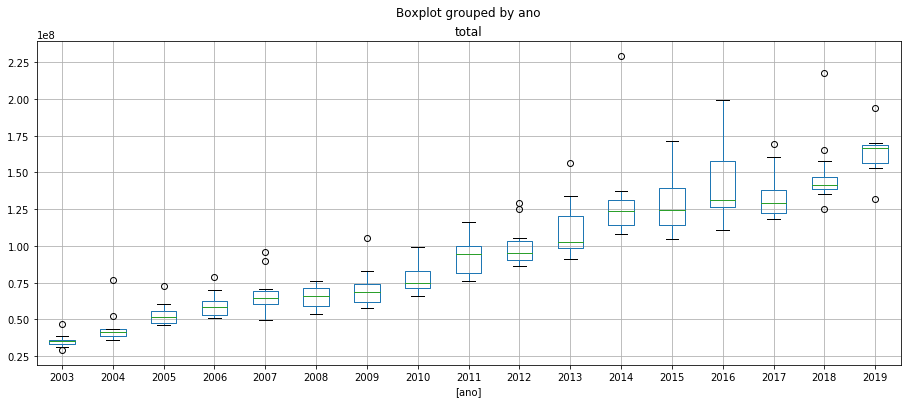

In [400]:
# Distribuição dos valores do dataset por ano
df = receitas_por_mes_ano.reset_index()
df['ano'] = df.dt_mesano.dt.year
df.boxplot(by='ano')

Agora vamos ver esse mesmo gráfico agrupado mensalmente. Os dados agora não mostram mais dados observados como **outliers**, isso mostra que a distribuição dos valores das receitas nos meses distribuídos pelos anos tiveram um comportamento normal para os padrões de cada mês.

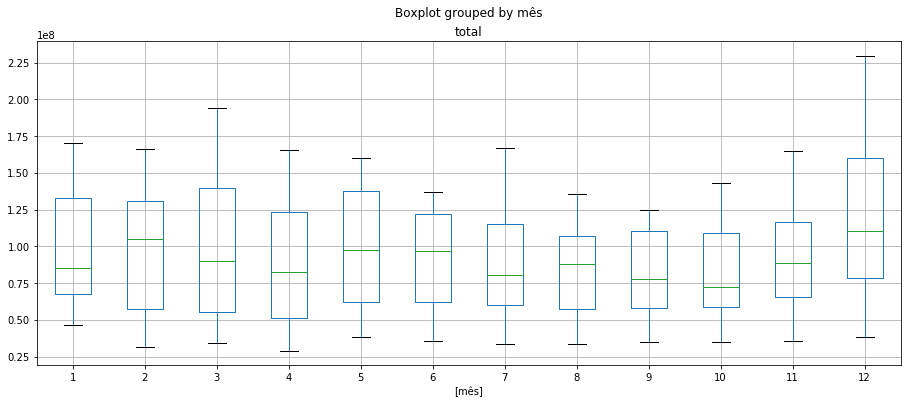

In [401]:
# Distribuição dos valores do dataset por ano
df = receitas_por_mes_ano.reset_index()
df['mês'] = df.dt_mesano.dt.month
df.boxplot(by='mês')

In [462]:
receitas_por_mes_ano.total['2014-12-01'] = receitas_por_mes_ano.total['2016-11-01']
# receitas_por_mes_ano.total['2014-12-01'] = receitas_por_mes_ano.total['2016-12-01']
# receitas_por_mes_ano.total['2018-12-01'] = receitas_por_mes_ano.total['2016-12-01']

#### Outliers
  
  Para os **outliers**, como o gráfico da distribuição por mês/ano não mostrou valores significantes vou considerar todos os valores informados, não realizando nenhum tipo de ajuste nos dados originais.

#### 3. Como se comporta a série temporal do total de receitas mês/ano do Município?


Para se inicar o estudo da série temporal, vou primeiro dividir o dataset em dois tipos de bases. Uma base de treinamento do modelo preditivo (com aproximadamente 80% dos dados) e uma outra base de teste para validação do modelo (com os 20% restantes).

In [463]:
# Dividindo as bases
qtd_meses_teste = 41
ts_treino = receitas_por_mes_ano.iloc[:-qtd_meses_teste,0:1].copy()
ts_teste = receitas_por_mes_ano.iloc[-qtd_meses_teste:,0:1].copy()

In [464]:
# Início da base de teste
ts_teste.head()

,total
dt_mesano,
2016-03-01,1.620259e+08
2016-04-01,1.174910e+08
2016-05-01,1.562148e+08
2016-06-01,1.285613e+08
2016-07-01,1.295133e+08


In [465]:
# Final da base de treino
ts_treino.tail()

,total
dt_mesano,
2015-10-01,1.123847e+08
2015-11-01,1.075520e+08
2015-12-01,1.714181e+08
2016-01-01,1.331819e+08
2016-02-01,1.366303e+08


Vamos agora iniciar o estudo da série temporal utilizando a base de treinamento.
  
  
Vamos falar sobre o gráfico criado apartir das receitas recebidas por mês pela Prefeitura Municipal de João Pessoa durante os anos de 2003 e 2016. O ciclo escolhido será de 12 meses, levando em consideração o ano fiscal que a prefeitura deve seguir para o recebimento das receitas. A motivação é identificar no gráfico características de **Tendência, Sazonalidade e Resíduo**. Vejamos o gráfico abaixo:

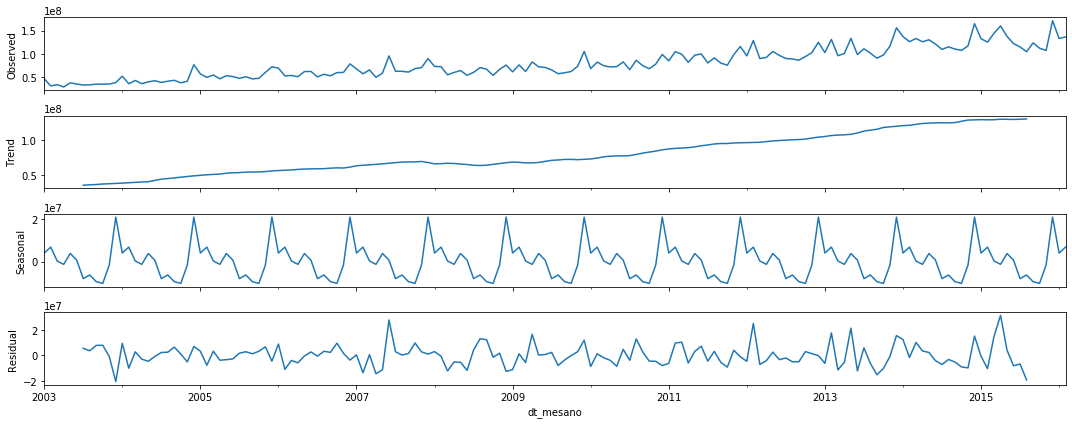

In [466]:
# Decomposição dos dados da base de treinamento
decomposicao = seasonal_decompose(ts_treino, freq=12)
imagem = decomposicao.plot()

#### Tendência
  
  No gráfico *Trend* acima é possível identificar uma crescente na tendência dos dados no gráfico. Isso também fica evidente no gráfico original da série pois os valores tendem a crecer com o decorrer do tempo. O teste de *Dickey-Fuller* pode ser aplicado para mostrar se a série é probabilísticamente estacionária caso o valor *p-value* seja menor que 5%.

In [467]:
# Teste Dickey-Fuller
teste_adf(ts_treino.total)

ADF Statistic: 0.669091
p-value: 0.989200
Critical Values:
	1%: -3.476
	5%: -2.882
	10%: -2.577


O *p-value* é muito alto aqui, sendo 98%. Vamos precisar aplicar técnicas para estacionar a série.

#### Aplicando diferenciação
  
A diferenciação é usada para remover os sinais de tendência na tentativa de tornar a série estacionária.

In [468]:
# Aplicando a diferenciação na série e removendo dados nulos
ts_treino_diff_1 = ts_treino.diff()
ts_treino_diff_1 = ts_treino_diff_1.dropna()

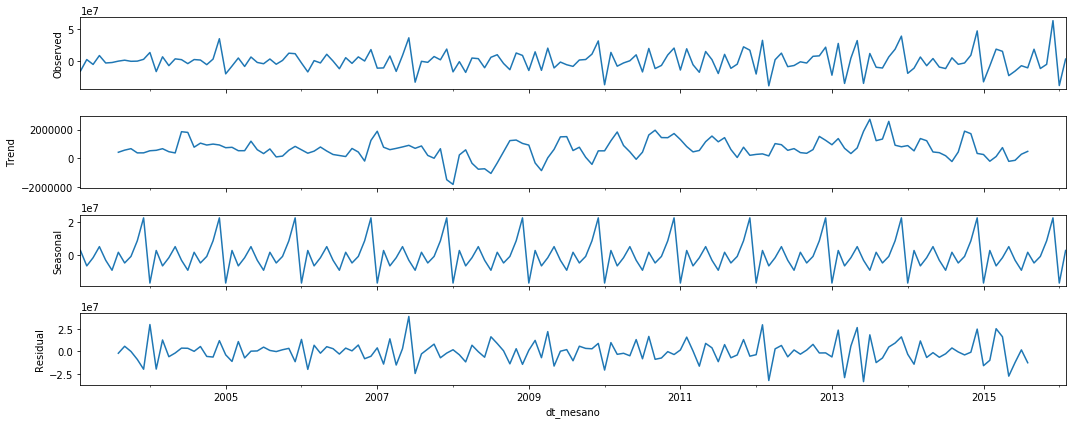

In [469]:
# Decomposição dos dados da base de treinamento
decomposicao = seasonal_decompose(ts_treino_diff_1, freq=12)
imagem = decomposicao.plot()

Podemos notar agora que a tendência (gráfico *Trend*) varia em torno de 0. Vamos executar novamente o teste e validar o *p-value*.

In [470]:
# Teste Dickey-Fuller
teste_adf(ts_treino_diff_1.total)

ADF Statistic: -13.619278
p-value: 0.000000
Critical Values:
	1%: -3.476
	5%: -2.882
	10%: -2.577


Com valor *p-value* 0 podemos considerar agora que a série é estacionária aplicando apenas **1** deferencial.

#### Autocorrelação (AR)

A autocorelação nos informará qual o grau de relação que cada dado tem com os demais dados passados da série. Isso irá ajudar a definir o valor *p* para ser utlizado no modelo preditivo.
  
Para isso, iremos utilizar o gráfico ACF (Autocorrelation Factor), que irá nos mostrar o número de *lags* estão fora do intervalo de confiança. Esse valor será o nosso AR.

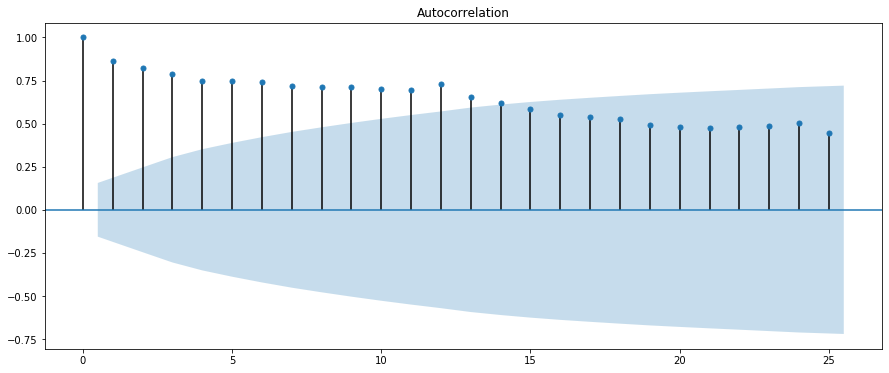

In [471]:
# Gráfico de autocorrelação
sm.graphics.tsa.plot_acf(ts_treino.values.squeeze(), lags=25)
plt.show()

Como o gráfico mostra, os valores ficam contidos no intervalo apartir do *lag* 15, então os valores a serem utilizados estará perto do valor *14*. Após alguns testes e verificando o AIC e BIC do modelo, decidi usar o valor *11*.

#### Médias Móveis (MA)

Para obter o valor das médias móveis e termos uma pista sobre o valor *q*, iremos utilizar o gráfico PACF (Partial Autocorrelation Factor).

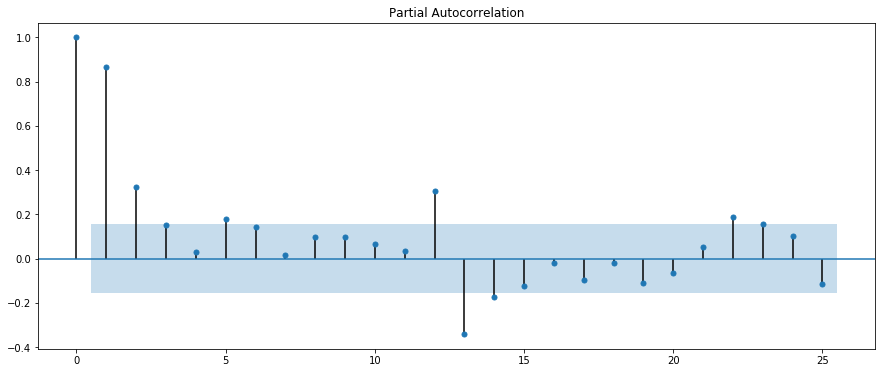

In [472]:
# Gráfico da autocorrelação parcial
sm.graphics.tsa.plot_pacf(ts_treino.values.squeeze(), lags=25)
plt.show()

Vemos aqui eu os dois primeiros valores tem uma significância correlativa alte em relação aos demais. Então usarei o valor 2 inicialmente para definir o valor *q* do modelo preditivo.
  
#### Criando o modelo preditivo e realizando a predição

  Definido os valores *p, d, q* para nosso modelo ARIMA, vamos criar o modelo e mostrar no gráfico como ficou a predição em relação aos dados de teste definidos anteriormente.

In [473]:
# Criando o modelo
modelo = ARIMA(ts_treino, order=(11,1,2), freq=ts_treino.index.inferred_freq)

In [474]:
# Ajustando o modelo de acordo com os parâmetros
modelo_ajustado = modelo.fit(disp=0)

In [475]:
# Exibe dados do modelo, como valores AIC e BIC obtidos.
modelo_ajustado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.total   No. Observations:                  157
Model:                ARIMA(11, 1, 2)   Log Likelihood               -2753.650
Method:                       css-mle   S.D. of innovations        9774435.507
Date:                Wed, 09 Oct 2019   AIC                           5537.300
Time:                        21:25:02   BIC                           5583.144
Sample:                    02-01-2003   HQIC                          5555.919
                         - 02-01-2016                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.714e+05   9.69e+04      5.898      0.000    3.81e+05    7.61e+05
ar.L1.D.total     -0.9139      0.113     -8.108      0.000      -1.135      -0.693
ar.L2.D.total     -0.9003      0.114     -7.913      0.000      -1.123      -0.677
ar.L3.D.total     -0.7466      0.103     -7.234      0.000      -0.949      -0.544
ar.L4.D.total     -0.8213      0.098     -8.372      0.000      -1.014      -0.629
ar.L5.D.total     -0.7868      0.103     -7.663      0.000      -0.988      -0.586
ar.L6.D.total     -0.7641      0.105     -7.249      0.000      -0.971      -0.558
ar.L7.D.total     -0.8092      0.098     -8.295      0.000      -1.000      -0.618
ar.L8.D.total     -0.7479      0.093     -8.016      0.000      -0.931      -0.565
ar.L9.D.total     -0.7923      0.093     -8.560      0.000      -0.974      -0.611
ar.L10.D.total    -0.7306      0.084     -8.720      0.000      -0.895      -0.566
ar.L11.D.total    -0.6445      0.065     -9.856      0.000      -0.773      -0.516
ma.L1.D.total      0.0843      0.145      0.581      0.562      -0.200       0.369
ma.L2.D.total      0.0438      0.161      0.272      0.786      -0.272       0.360
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.8853           -0.5039j            1.0186           -0.0824
AR.2             0.8853           +0.5039j            1.0186            0.0824
AR.3             0.5167           -0.9019j            1.0395           -0.1672
AR.4             0.5167           +0.9019j            1.0395            0.1672
AR.5            -0.0157           -1.0480j            1.0481           -0.2524
AR.6            -0.0157           +1.0480j            1.0481            0.2524
AR.7            -1.0518           -0.0000j            1.0518           -0.5000
AR.8            -0.8919           -0.5636j            1.0550           -0.4103
AR.9            -0.8919           +0.5636j            1.0550            0.4103
AR.10           -0.5352           -0.8886j            1.0374           -0.3363
AR.11           -0.5352           +0.8886j            1.0374            0.3363
MA.1            -0.9620           -4.6797j            4.7776           -0.2823
MA.2            -0.9620           +4.6797j            4.7776            0.2823
------------------------------------------------------------------------------
"""

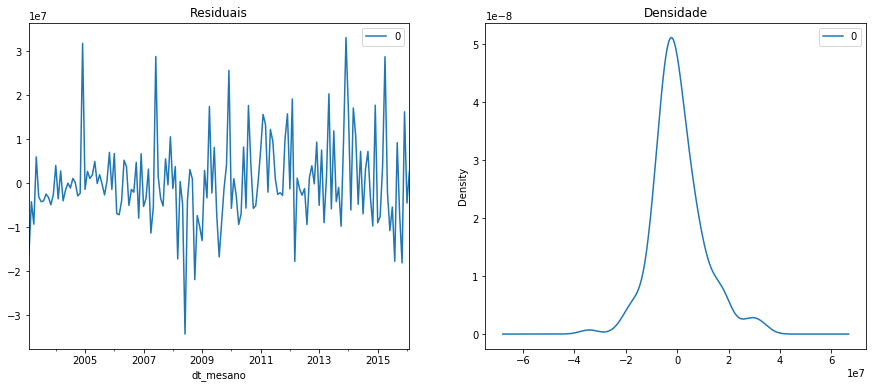

In [476]:
# Gráfico com os erros residuais do modelo ajustado
redisuais = pd.DataFrame(modelo_ajustado.resid)
fig, ax = plt.subplots(1,2)
redisuais.plot(title="Residuais", ax=ax[0])
redisuais.plot(kind='kde', title='Densidade', ax=ax[1])
plt.show()

Os resíduos ficam em torno de 0 com uma variação satisfatória. O único ponto que se distancia é dezembro de 2014, os demais pontos tendem a permanecer na média em torno de 0.

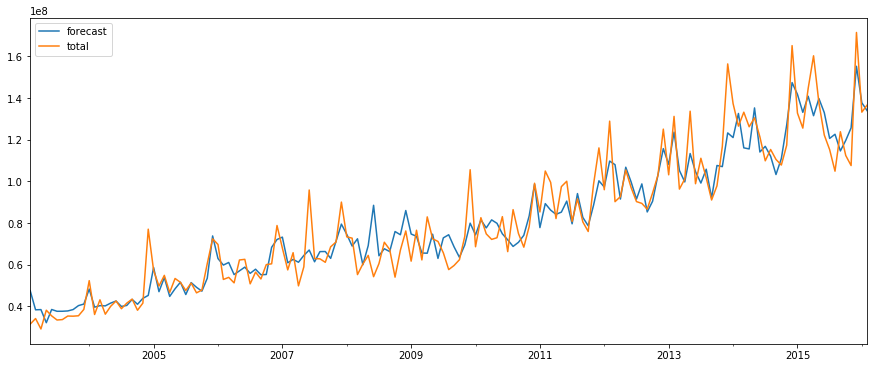

In [477]:
# Dados atuais x Modelo
modelo_ajustado.plot_predict(dynamic=False)
plt.show()

In [478]:
redisuais.describe()

,0
count,1.570000e+02
mean,3.641447e+05
std,9.890126e+06
min,-3.425156e+07
25%,-5.042517e+06
50%,-1.272412e+06
75%,4.237008e+06
max,3.309874e+07


#### 4. Como se fazer forecasting de valores orçamentários baseados no dataset?

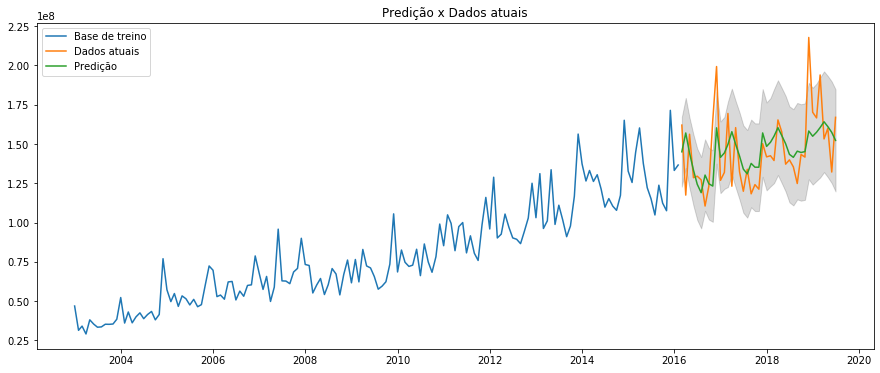

In [479]:
# Predição
fc, se, conf = fitted.forecast(41, alpha=0.05)

# Criando uma série partindo da predição
serie_predicao = pd.Series(fc, index=ts_teste.index)
serie_ic_inferior = pd.Series(conf[:, 0], index=ts_teste.index)
serie_ic_superior = pd.Series(conf[:, 1], index=ts_teste.index)

# Definindo o gráfico
plt.plot(ts_treino, label='Base de treino')
plt.plot(ts_teste, label='Dados atuais')
plt.plot(serie_predicao, label='Predição')
plt.fill_between(serie_ic_inferior.index, serie_ic_inferior, serie_ic_superior, 
                 color='k', alpha=.15)
plt.title('Predição x Dados atuais')
plt.legend(loc='upper left')
plt.show()

In [440]:
receitas_por_mes_ano.to_csv('receitas_por_mes_ano.csv',sep='|',encoding='utf8')